In [1]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='5adef59e-517d-4366-83ab-c2d7dfe182e9', project_access_token='p-f8ce0c95829e5ea8e60e71498fa3ff5207002bcb')
pc = project.project_context


# MARATÓN BEHIND THE CODE 2020

# DESAFÍO 8 - Digital House

El reto de Digital House tiene que ver con la misión y visión de la empresa; la cual busca transformar la vida de las personas, desarrollando competencias digitales, para que generen un impacto positivo en la sociedad. En ese sentido, Digital House busca a través de este desafío medir la empleabilidad de los cursos que disponibiliza en su plataforma, es decir que tan factible es que un alumno o egresado de Digital House acceda al mercado laboral o consiga un trabajo en su área luego de finalizar uno o varios de los cursos ofrecidos en la plataforma.

Entender que características o variables hacen que una persona sea más o menos empleable es fundamental para la empresa y para generar ese impacto positivo que busca aportar a la sociedad

<hr>

## Instalación de algunas bibliotecas de Python

In [ ]:
!pip install -U scikit-learn==0.23.2
!pip install -U pandas==1.1.1
!pip install -U seaborn==0.10.1
!pip install -U scipy

<hr>

## Descargue el conjunto de datos del desafío en formato .csv

In [2]:
import pandas as pd
import numpy as np

from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error, r2_score

from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
!wget --no-check-certificate --content-disposition https://raw.githubusercontent.com/vanderlei-test/654986294958/master/train_dataset_digitalhouse.csv
df_training_dataset = pd.read_csv(r'train_dataset_digitalhouse.csv')
df_training_dataset.tail()

--2020-09-17 22:32:51--  https://raw.githubusercontent.com/vanderlei-test/654986294958/master/train_dataset_digitalhouse.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 654532 (639K) [text/plain]
Saving to: ‘train_dataset_digitalhouse.csv.2’

100%[======================================>] 654,532     --.-K/s   in 0.02s   

2020-09-17 22:32:51 (26.3 MB/s) - ‘train_dataset_digitalhouse.csv.2’ saved [654532/654532]



,Unnamed: 0,EDAD,GENERO,RESIDENCIA,NV_ESTUDIO,ESTUDIO_PREV,TRACK_DH,AVG_DH,MINUTES_DH,EXPERIENCIA,DIAS_EMP
8990,9995,29.0,MASCULINO,ARGENTINA,TERTIARY,DEVELOPMENT,NaN,4.0,4701.6,9.1,86.0
8991,9996,34.0,NaN,ARGENTINA,UNIVERSITARY,ENGINEERING,PROGRAMACION,3.4,4646.2,16.8,95.0
8992,9997,28.0,FEMENINO,ARGENTINA,POST_GRADUATE,ENGINEERING,EJECUTIVO,NaN,3315.1,5.6,95.0
8993,9998,23.0,MASCULINO,MEXICO,TERTIARY,ENGINEERING,PROGRAMACION,3.3,4437.8,0.9,87.0
8994,9999,36.0,MASCULINO,ARGENTINA,UNIVERSITARY,COMMERCIAL,DATA,3.4,4600.8,19.6,88.0


## En el conjunto de datos proporcionado, tenemos las siguientes columnas:

* Unnamed: 0
* EDAD
* GENERO
* RESIDENCIA
* NV_ESTUDIO
* ESTUDIO_PREV
* TRACK_DH
* AVG_DH
* MINUTES_DH
* EXPERIENCIA
* **DIAS_EMP = El valor "target" que se va a predecir**

Podemos verificar fácilmente que faltan valores usando el siguiente código:

```df_training_dataset.info()```

Debe manejar cuidadosamente estos valores faltantes antes de crear un modelo de regresión.

In [4]:
print("Cols: ", len(df_training_dataset.columns), " Rows: ", len(df_training_dataset))

Cols:  11  Rows:  8995


In [5]:
print("Valores nulos del dataSet: \n\n{}\n".format(df_training_dataset.isnull().sum(axis = 0)))

Valores nulos del dataSet: 

Unnamed: 0         0
EDAD            1327
GENERO          1375
RESIDENCIA      1357
NV_ESTUDIO      1372
ESTUDIO_PREV    1330
TRACK_DH        1281
AVG_DH          1344
MINUTES_DH      1376
EXPERIENCIA     1377
DIAS_EMP           0
dtype: int64



<hr>

## Algunos consejos antes de entrenar a un modelo:

1. Manejar valores perdidos

2. Manejar variables categóricas

<hr>

## A continuación, le brindamos una plantilla simple para que sepa cómo estructurar las entradas y salidas de su modelo

### Removiendo columnas

In [6]:
df_training_dataset_1 = df_training_dataset.drop(columns=['Unnamed: 0'], inplace=False)
df_training_dataset_1.tail()

,EDAD,GENERO,RESIDENCIA,NV_ESTUDIO,ESTUDIO_PREV,TRACK_DH,AVG_DH,MINUTES_DH,EXPERIENCIA,DIAS_EMP
8990,29.0,MASCULINO,ARGENTINA,TERTIARY,DEVELOPMENT,NaN,4.0,4701.6,9.1,86.0
8991,34.0,NaN,ARGENTINA,UNIVERSITARY,ENGINEERING,PROGRAMACION,3.4,4646.2,16.8,95.0
8992,28.0,FEMENINO,ARGENTINA,POST_GRADUATE,ENGINEERING,EJECUTIVO,NaN,3315.1,5.6,95.0
8993,23.0,MASCULINO,MEXICO,TERTIARY,ENGINEERING,PROGRAMACION,3.3,4437.8,0.9,87.0
8994,36.0,MASCULINO,ARGENTINA,UNIVERSITARY,COMMERCIAL,DATA,3.4,4600.8,19.6,88.0


### Removendo valores NaN

#### Mantener registros que tengan por lo menos 8 valores no nulos

In [7]:
a = df_training_dataset_1.isna().sum(axis = 1)

In [8]:
Counter(a[a>0])

Counter({1: 3279, 3: 980, 2: 2294, 4: 265, 5: 41, 6: 10, 7: 1})

In [212]:
df_training_dataset_2 = df_training_dataset_1.dropna(thresh=8, inplace=False)

In [213]:
df_training_dataset_2.reset_index(drop=True, inplace=True)

In [214]:
print("Cols: ", len(df_training_dataset_2.columns), " Rows: ", len(df_training_dataset_2))

Cols:  10  Rows:  7698


#### Valores NaN, numéricos y categóricos.

In [215]:
for feature in ['EDAD', 'EXPERIENCIA', 'AVG_DH', 'MINUTES_DH']:
    df_training_dataset_2.loc[:, (feature)].fillna(df_training_dataset_2[feature].mean(), inplace=True)

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/series.py:4523: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [216]:
for feature in ['GENERO', 'RESIDENCIA', 'NV_ESTUDIO', 'ESTUDIO_PREV', 'TRACK_DH']:
    df_training_dataset_2[feature].fillna(df_training_dataset_2[feature].value_counts().idxmax(), inplace=True)

In [217]:
print("Valores nulos del dataSet: \n\n{}\n".format(df_training_dataset_2.isnull().sum(axis = 0)))

Valores nulos del dataSet: 

EDAD            0
GENERO          0
RESIDENCIA      0
NV_ESTUDIO      0
ESTUDIO_PREV    0
TRACK_DH        0
AVG_DH          0
MINUTES_DH      0
EXPERIENCIA     0
DIAS_EMP        0
dtype: int64



In [218]:
print("Cols: ", len(df_training_dataset_2.columns), " Rows: ", len(df_training_dataset_2))

Cols:  10  Rows:  7698


MASCULINO    5580
FEMENINO     2118
Name: GENERO, dtype: int64


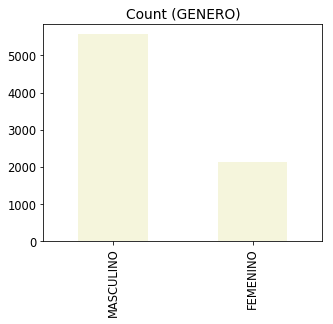

In [219]:
plt.rcParams.update({'figure.figsize': (5.0, 4.0)})
plt.rcParams.update({'font.size': 11.5})

count_genero = df_training_dataset_2.GENERO.value_counts()
count_nvestudio = df_training_dataset_2.NV_ESTUDIO.value_counts()

count_genero.plot(kind='bar', title='Count (GENERO)', color='beige');
print(count_genero)

UNIVERSITARY     5270
TERTIARY         1562
POST_GRADUATE     866
Name: NV_ESTUDIO, dtype: int64


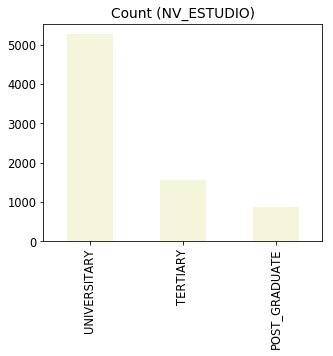

In [220]:
count_nvestudio.plot(kind='bar', title='Count (NV_ESTUDIO)', color='beige');
print(count_nvestudio)

#### Label enconding

In [221]:
le = LabelEncoder()
def labelEnconding(feature_name, dataset):
    target_label = pd.DataFrame(le.fit_transform(dataset[feature_name]))
    dataset.drop(columns=[feature_name], inplace=True)
    dataset[feature_name] = target_label

In [222]:
df_training_dataset_3 = df_training_dataset_2.copy()

for i in ['GENERO', 'RESIDENCIA', 'NV_ESTUDIO', 'ESTUDIO_PREV', 'TRACK_DH']:
    labelEnconding(i, df_training_dataset_3)

In [223]:
df_training_dataset_3.tail()

,EDAD,AVG_DH,MINUTES_DH,EXPERIENCIA,DIAS_EMP,GENERO,RESIDENCIA,NV_ESTUDIO,ESTUDIO_PREV,TRACK_DH
7693,29.0,4.000000,4701.6,9.1,86.0,1,0,1,2,0
7694,34.0,3.400000,4646.2,16.8,95.0,1,0,2,3,3
7695,28.0,3.502687,3315.1,5.6,95.0,0,0,0,3,1
7696,23.0,3.300000,4437.8,0.9,87.0,1,2,1,3,3
7697,36.0,3.400000,4600.8,19.6,88.0,1,0,2,1,0


In [224]:
print("Cols: ", len(df_training_dataset_3.columns), " Rows: ", len(df_training_dataset_3))

Cols:  10  Rows:  7698


In [225]:
new_index = ['EDAD', 'AVG_DH', 'MINUTES_DH', 'EXPERIENCIA', 'GENERO', 'RESIDENCIA', 'NV_ESTUDIO', 'ESTUDIO_PREV', 'TRACK_DH', 'DIAS_EMP']
df_training_dataset_3  = df_training_dataset_3.reindex(new_index, axis='columns')
df_training_dataset_3.tail()

,EDAD,AVG_DH,MINUTES_DH,EXPERIENCIA,GENERO,RESIDENCIA,NV_ESTUDIO,ESTUDIO_PREV,TRACK_DH,DIAS_EMP
7693,29.0,4.000000,4701.6,9.1,1,0,1,2,0,86.0
7694,34.0,3.400000,4646.2,16.8,1,0,2,3,3,95.0
7695,28.0,3.502687,3315.1,5.6,0,0,0,3,1,95.0
7696,23.0,3.300000,4437.8,0.9,1,2,1,3,3,87.0
7697,36.0,3.400000,4600.8,19.6,1,0,2,1,0,88.0


#### Matriz de correlaciones

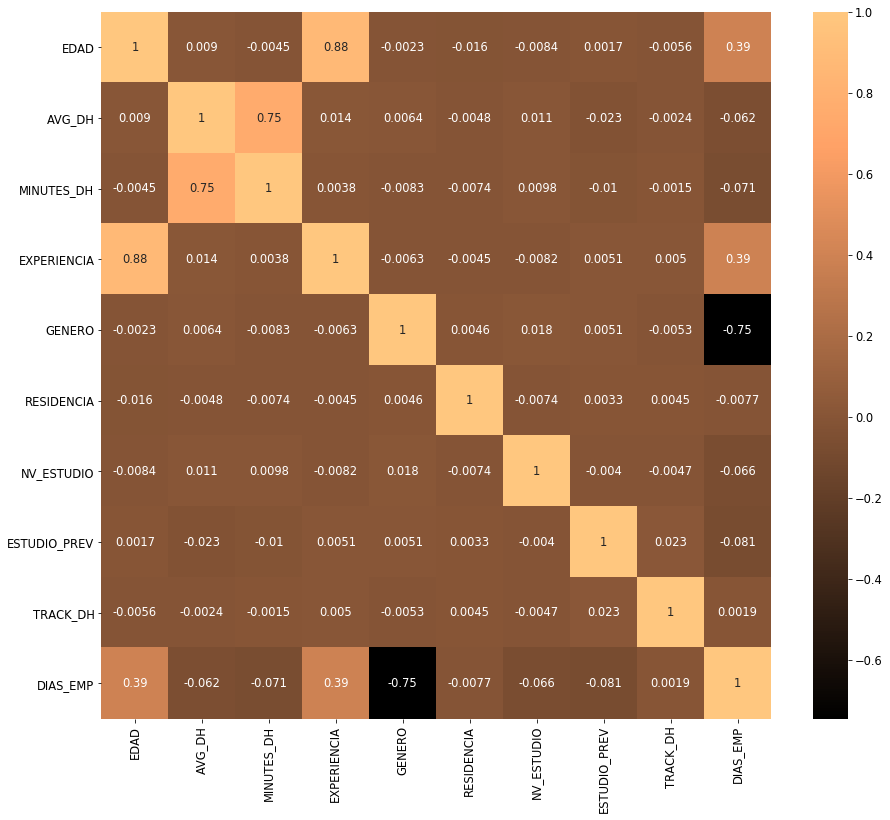

In [226]:
#Using Pearson Correlation
plt.figure(figsize=(15,13))
cor = df_training_dataset_3.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.copper)
plt.show()

In [227]:
#Correlation with output variable
cor_target = abs(cor["DIAS_EMP"])#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.0]
relevant_features

EDAD            0.394328
AVG_DH          0.061510
MINUTES_DH      0.070740
EXPERIENCIA     0.389879
GENERO          0.745246
RESIDENCIA      0.007748
NV_ESTUDIO      0.066146
ESTUDIO_PREV    0.081078
TRACK_DH        0.001872
DIAS_EMP        1.000000
Name: DIAS_EMP, dtype: float64

In [228]:
print(df_training_dataset_3[["AVG_DH","MINUTES_DH"]].corr())
print(df_training_dataset_3[["EDAD","EXPERIENCIA"]].corr())

              AVG_DH  MINUTES_DH
AVG_DH      1.000000    0.751732
MINUTES_DH  0.751732    1.000000
                 EDAD  EXPERIENCIA
EDAD         1.000000     0.876843
EXPERIENCIA  0.876843     1.000000


### Codificando variables categóricas

In [229]:
df_training_dataset_4 = df_training_dataset_3.drop(columns=['EXPERIENCIA', 'AVG_DH', 'RESIDENCIA', 'TRACK_DH'], inplace=False)
df_training_dataset_4.tail()

,EDAD,MINUTES_DH,GENERO,NV_ESTUDIO,ESTUDIO_PREV,DIAS_EMP
7693,29.0,4701.6,1,1,2,86.0
7694,34.0,4646.2,1,2,3,95.0
7695,28.0,3315.1,0,0,3,95.0
7696,23.0,4437.8,1,1,3,87.0
7697,36.0,4600.8,1,2,1,88.0


In [230]:
# Columnas One-hot-encoding del dataset usando el metodo de Pandas ``get_dummies`` (demontración)
df_training_dataset_5 = pd.get_dummies(df_training_dataset_4, columns=['GENERO', 'ESTUDIO_PREV', 'NV_ESTUDIO'])
df_training_dataset_5.tail()

,EDAD,MINUTES_DH,DIAS_EMP,GENERO_0,GENERO_1,ESTUDIO_PREV_0,ESTUDIO_PREV_1,ESTUDIO_PREV_2,ESTUDIO_PREV_3,ESTUDIO_PREV_4,NV_ESTUDIO_0,NV_ESTUDIO_1,NV_ESTUDIO_2
7693,29.0,4701.6,86.0,0,1,0,0,1,0,0,0,1,0
7694,34.0,4646.2,95.0,0,1,0,0,0,1,0,0,0,1
7695,28.0,3315.1,95.0,1,0,0,0,0,1,0,1,0,0
7696,23.0,4437.8,87.0,0,1,0,0,0,1,0,0,1,0
7697,36.0,4600.8,88.0,0,1,0,1,0,0,0,0,0,1


### Seleccionando las columnas "features" y "target"

In [231]:
features_columns = np.array(df_training_dataset_5.columns)
features_columns = np.delete(features_columns, np.where(features_columns == 'DIAS_EMP'))
len(features_columns)

12

In [232]:
features = df_training_dataset_5[
    features_columns
]

target = df_training_dataset_5['DIAS_EMP']

sc_features = 2

#### CrossValidation

In [233]:
X_train, X_test, y_train, y_test = train_test_split(features, target, train_size=0.99, random_state=0)

In [234]:
sc = StandardScaler()
X_train.iloc[:, :sc_features] = sc.fit_transform(X_train.iloc[:, :sc_features])
X_test.iloc[:, :sc_features] = sc.transform(X_test.iloc[:, :sc_features])

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [235]:
X_train.head()

,EDAD,MINUTES_DH,GENERO_0,GENERO_1,ESTUDIO_PREV_0,ESTUDIO_PREV_1,ESTUDIO_PREV_2,ESTUDIO_PREV_3,ESTUDIO_PREV_4,NV_ESTUDIO_0,NV_ESTUDIO_1,NV_ESTUDIO_2
7151,-0.000595,1.712928,1,0,0,0,1,0,0,0,0,1
5338,-0.004982,-0.104184,0,1,0,0,0,1,0,0,0,1
4807,1.052832,0.301965,0,1,0,1,0,0,0,0,1,0
6319,-0.004982,0.932819,1,0,0,1,0,0,0,0,1,0
3760,-0.851233,0.619545,1,0,0,0,0,1,0,0,0,1


#### Test model

In [236]:
regressor = LinearRegression()

In [111]:
regressor = SVR(kernel='rbf')

#### CrossValScore

In [237]:
all_accuracies = cross_val_score(estimator=regressor, X=X_train, y=y_train, cv=10)

In [238]:
print(all_accuracies)

[0.78703157 0.74599328 0.76156427 0.79995941 0.76347858 0.78940521
 0.77795725 0.7799718  0.78400365 0.77405124]


In [239]:
print(all_accuracies.mean())

0.7763416259154738


#### KFolds

In [240]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)  

all_accuracies = cross_val_score(estimator=regressor, X=X_train, y=y_train, cv=skf)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


In [241]:
print(all_accuracies)

[0.77384451 0.79125845 0.78060583 0.77863179 0.75667844 0.78563369
 0.7761847  0.78942634 0.77011459 0.76841992]


In [242]:
print(all_accuracies.mean())

0.7770798260222876


### Dividiendo el conjunto de datos para una "prueba ciega"

In [243]:
X_train, X_test, y_train, y_test = train_test_split(features, target, train_size=0.8, random_state=337)

In [244]:
sc = StandardScaler()
X_train.iloc[:, :sc_features] = sc.fit_transform(X_train.iloc[:, :sc_features])
X_test.iloc[:, :sc_features] = sc.transform(X_test.iloc[:, :sc_features])

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [245]:
X_test.tail()

,EDAD,MINUTES_DH,GENERO_0,GENERO_1,ESTUDIO_PREV_0,ESTUDIO_PREV_1,ESTUDIO_PREV_2,ESTUDIO_PREV_3,ESTUDIO_PREV_4,NV_ESTUDIO_0,NV_ESTUDIO_1,NV_ESTUDIO_2
5779,0.210914,0.420802,0,1,0,0,1,0,0,0,0,1
4348,0.848746,0.551427,0,1,0,0,0,1,0,0,0,1
806,0.848746,0.232188,0,1,0,0,0,1,0,0,0,1
4484,0.210914,1.216761,0,1,0,0,0,1,0,0,0,1
4098,-0.852140,-1.569912,0,1,0,0,0,1,0,0,0,1


### Entrenando un modelo de regresión lineal simple

In [246]:
regression_model = LinearRegression().fit(X_train, y_train)

### Evaluando el modelo de regresión con el método  "score()" de sklearn

In [247]:
regression_model.score(X_test, y_test)

0.7951621465189022

In [248]:
y_pred = regression_model.predict(X_test)

In [249]:
# The coefficients
print('Coefficients: \n', regression_model.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))



Coefficients: 
 [ 2.24939835 -0.45123961  4.71525844 -4.71525844  1.65953528 -1.40717552
 -0.76651502 -2.20007746  2.71423271 -1.26315476  1.91588963 -0.65273487]
Mean squared error: 6.85
Coefficient of determination: 0.80


<hr>

## Completar los datos necesarios para entregar la solución

### Como entrega de su solución, esperamos los resultados numéricos predichos por su modelo. Como entrada utilizará el archivo "to_be_scored.csv"

In [250]:
!wget --no-check-certificate --content-disposition https://raw.githubusercontent.com/vanderlei-test/654986294958/master/to_be_scored_digitalhouse.csv
df_to_be_scored = pd.read_csv(r'to_be_scored_digitalhouse.csv')
df_to_be_scored.tail()

--2020-09-17 22:49:22--  https://raw.githubusercontent.com/vanderlei-test/654986294958/master/to_be_scored_digitalhouse.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67308 (66K) [text/plain]
Saving to: ‘to_be_scored_digitalhouse.csv.5’

100%[======================================>] 67,308      --.-K/s   in 0.005s  

2020-09-17 22:49:22 (14.2 MB/s) - ‘to_be_scored_digitalhouse.csv.5’ saved [67308/67308]



,Unnamed: 0,EDAD,GENERO,RESIDENCIA,NV_ESTUDIO,ESTUDIO_PREV,TRACK_DH,AVG_DH,MINUTES_DH,EXPERIENCIA,Unnamed: 10
995,995,33.0,MASCULINO,ARGENTINA,UNIVERSITARY,COMMERCIAL,PROGRAMACION,3.6,4576.5,15.1,NaN
996,996,40.0,MASCULINO,ARGENTINA,TERTIARY,COMMERCIAL,PROGRAMACION,3.4,4542.9,26.1,NaN
997,997,NaN,FEMENINO,ARGENTINA,UNIVERSITARY,ENGINEERING,DATA,3.4,NaN,27.4,NaN
998,998,NaN,MASCULINO,MEXICO,UNIVERSITARY,ENGINEERING,DATA,3.7,4730.4,1.1,NaN
999,999,36.0,NaN,ARGENTINA,UNIVERSITARY,NaN,PROGRAMACION,3.3,4506.5,20.4,NaN


In [ ]:
Counter(df_to_be_scored['NV_ESTUDIO'])

In [ ]:
Counter(df_to_be_scored['ESTUDIO_PREV'])

In [ ]:
Counter(df_to_be_scored['TRACK_DH'])

#### Valores NaN

In [251]:
a = df_to_be_scored.isna().sum(axis = 1)

In [252]:
Counter(a[a>0])

Counter({2: 372, 1: 233, 4: 104, 3: 256, 5: 29, 6: 5, 8: 1})

In [253]:
for feature in ['EDAD', 'AVG_DH', 'MINUTES_DH', 'EXPERIENCIA']:
    df_to_be_scored.loc[:, (feature)].fillna(df_to_be_scored[feature].mean(), inplace=True)

In [254]:
for feature in ['GENERO', 'RESIDENCIA', 'NV_ESTUDIO', 'ESTUDIO_PREV', 'TRACK_DH']:
    df_to_be_scored[feature].fillna(df_to_be_scored[feature].value_counts().idxmax(), inplace=True)

In [255]:
print("Valores nulos del dataSet: \n\n{}\n".format(df_to_be_scored.isnull().sum(axis = 0)))

Valores nulos del dataSet: 

Unnamed: 0         0
EDAD               0
GENERO             0
RESIDENCIA         0
NV_ESTUDIO         0
ESTUDIO_PREV       0
TRACK_DH           0
AVG_DH             0
MINUTES_DH         0
EXPERIENCIA        0
Unnamed: 10     1000
dtype: int64



#### Drop columns

In [256]:
df_to_be_scored_1 = df_to_be_scored.drop(columns=['Unnamed: 0', 'Unnamed: 10', 'EXPERIENCIA', 'AVG_DH', 'RESIDENCIA', 'TRACK_DH'], inplace=False)
df_to_be_scored_1.tail()

,EDAD,GENERO,NV_ESTUDIO,ESTUDIO_PREV,MINUTES_DH
995,33.000000,MASCULINO,UNIVERSITARY,COMMERCIAL,4576.500000
996,40.000000,MASCULINO,TERTIARY,COMMERCIAL,4542.900000
997,34.192799,FEMENINO,UNIVERSITARY,ENGINEERING,4466.270335
998,34.192799,MASCULINO,UNIVERSITARY,ENGINEERING,4730.400000
999,36.000000,MASCULINO,UNIVERSITARY,ENGINEERING,4506.500000


#### One hot encoding

In [257]:
df_to_be_scored_2 = pd.get_dummies(df_to_be_scored_1, columns=['GENERO', 'ESTUDIO_PREV', 'NV_ESTUDIO'])
df_to_be_scored_2.tail()

,EDAD,MINUTES_DH,GENERO_FEMENINO,GENERO_MASCULINO,ESTUDIO_PREV_BUSINESS,ESTUDIO_PREV_COMMERCIAL,ESTUDIO_PREV_DEVELOPMENT,ESTUDIO_PREV_ENGINEERING,ESTUDIO_PREV_MARKETING,NV_ESTUDIO_POST_GRADUATE,NV_ESTUDIO_TERTIARY,NV_ESTUDIO_UNIVERSITARY
995,33.000000,4576.500000,0,1,0,1,0,0,0,0,0,1
996,40.000000,4542.900000,0,1,0,1,0,0,0,0,1,0
997,34.192799,4466.270335,1,0,0,0,0,1,0,0,0,1
998,34.192799,4730.400000,0,1,0,0,0,1,0,0,0,1
999,36.000000,4506.500000,0,1,0,0,0,1,0,0,0,1


#### Scaler

In [258]:
sc = StandardScaler()
df_to_be_scored_2.iloc[:, :sc_features] = sc.fit_transform(df_to_be_scored_2.iloc[:, :sc_features])

In [259]:
df_to_be_scored_2.head()

,EDAD,MINUTES_DH,GENERO_FEMENINO,GENERO_MASCULINO,ESTUDIO_PREV_BUSINESS,ESTUDIO_PREV_COMMERCIAL,ESTUDIO_PREV_DEVELOPMENT,ESTUDIO_PREV_ENGINEERING,ESTUDIO_PREV_MARKETING,NV_ESTUDIO_POST_GRADUATE,NV_ESTUDIO_TERTIARY,NV_ESTUDIO_UNIVERSITARY
0,1.954455,0.192890,0,1,0,0,0,1,0,1,0,0
1,1.732540,0.399823,1,0,0,1,0,0,0,0,0,1
2,0.179130,0.481922,1,0,0,0,1,0,0,0,0,1
3,0.179130,0.656646,0,1,0,0,1,0,0,0,1,0
4,0.401046,0.538970,0,1,0,1,0,0,0,1,0,0


# ¡Atención!

### El marco de datos ``to_be_scored`` es su "hoja de evaluación". Tenga en cuenta que la columna "target" no existe en esta muestra, por lo que no se puede utilizar para modelos de entrenamiento basados en el aprendizaje supervisado.

# ¡Atención!

### Debes realizar los mismos pasos de procesamiento previo que hiciste en el conjunto de datos de entrenamiento antes de calificar la "hoja de respuestas"

<hr>

### Hacer las predicciones con el método "predict()" de sklearn y agregar los resultados en el marco de datos de la "hoja de evaluación"

In [ ]:
y_pred = regression_model.predict(df_to_be_scored_2)
df_to_be_scored_2['target'] = y_pred
df_to_be_scored_2.tail()

In [ ]:
Counter(y_pred)

In [ ]:
print("Cols: ", len(df_to_be_scored_2.columns), " Rows: ", len(df_to_be_scored_2))

# ¡Atención!

### La columna agregada con los resultados debe llamarse "target", de lo contrario, su envío fallará.

<hr>

### Exportar el marco de datos de resultados como un archivo .csv a su proyecto de Watson Studio.

In [ ]:
project.save_data(file_name="results.csv", data=df_to_be_scored_2.to_csv(index=False))